In [3]:
# imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as pl

from torch.utils.data import DataLoader, Dataset, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# import data
from spotify_data import grouped_data, categorical_columns, string_columns

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
response_variable = "track_genre"

# remove string columns and one-hot encode
Y = grouped_data[response_variable]
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X = grouped_data.drop(columns=[response_variable, *string_columns])
X = pd.get_dummies(
    X,
    columns=[col for col in categorical_columns if col != response_variable],
    drop_first=True
)

# split data
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y_encoded,
    test_size=0.2,
    random_state=42
)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long).to(device)

# create dataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# create dataloaders
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
)


In [23]:
# Create model

class SpotifyModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        lr: float = 0.01,
        hidden_dim: int = 64,
        dropout_rate: float = 0.5
    ):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1),
        )
        self.epoch_metrics = []
        self.train_metrics_stack = []
        self.validation_metrics_stack = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log("train_loss", loss)
        self.train_metrics_stack.append({
            'train_loss': loss,
        })
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        self.validation_metrics_stack.append({
            'val_loss': loss,
            'val_acc': acc
        })
        return loss

    def on_validation_epoch_end(self):
        # sum in validation stack
        if len(self.validation_metrics_stack) == 0:
            return
        if len(self.train_metrics_stack) == 0:
            return
        val_loss = torch.stack([x['val_loss'] for x in self.validation_metrics_stack]).mean()
        val_acc = torch.stack([x['val_acc'] for x in self.validation_metrics_stack]).mean()
        train_loss = torch.stack([x['train_loss'] for x in self.train_metrics_stack]).mean()
        self.epoch_metrics.append({
            'val_loss': val_loss.cpu(),
            'val_acc': val_acc.cpu(),
            'train_loss': train_loss.cpu(),
        })
        # clear stack
        self.validation_metrics_stack = []
        self.train_metrics_stack = []


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]


In [24]:
input_dim = X_train.shape[1]
output_dim = len(label_encoder.classes_)
lr = 0.01

model = SpotifyModel(input_dim, output_dim, lr).to(device)

# train model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader, validation_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.5 K  | train
---------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


c:\Users\Zane Clark\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Zane Clark\.pyenv\pyenv-win\versions\3.12.0\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 1425/1425 [00:07<00:00, 189.38it/s, v_num=39]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1425/1425 [00:07<00:00, 189.25it/s, v_num=39]


In [25]:
# evaluate model
model.eval()
with torch.no_grad():
    outputs = model.to(device)(X_val_tensor.to(device)).cpu()
    _, predicted = torch.max(outputs.data, 1)
    class_report = classification_report(
        Y_val,
        predicted,
        target_names=label_encoder.classes_,
        zero_division=1
    )
model.train()

print(class_report)

              precision    recall  f1-score   support

   classical       1.00      0.00      0.00       584
  electronic       0.48      0.60      0.53      4041
        folk       1.00      0.00      0.00      1211
     hip-hop       1.00      0.00      0.00       599
        jazz       1.00      0.00      0.00       855
       metal       1.00      0.00      0.00      1218
        misc       0.35      0.71      0.47      6068
         pop       1.00      0.00      0.00      1813
        rock       1.00      0.00      0.00      2150
       world       0.37      0.49      0.42      4261

    accuracy                           0.39     22800
   macro avg       0.82      0.18      0.14     22800
weighted avg       0.62      0.39      0.30     22800



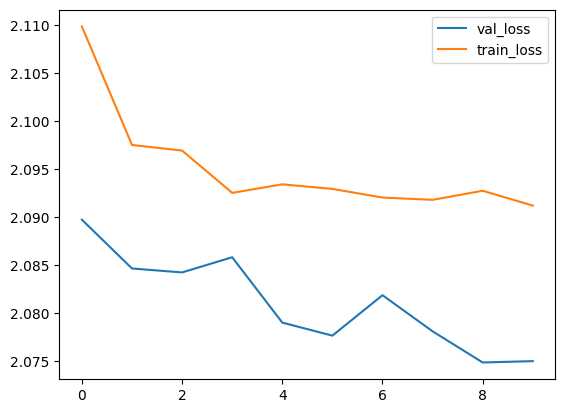

In [26]:
# Graph epoch metrics
import matplotlib.pyplot as plt

# plot epoch to val loss and train loss
plt.plot([x['val_loss'].cpu() for x in model.epoch_metrics], label='val_loss')
plt.plot([x['train_loss'].cpu() for x in model.epoch_metrics], label='train_loss')
plt.legend()
plt.show()


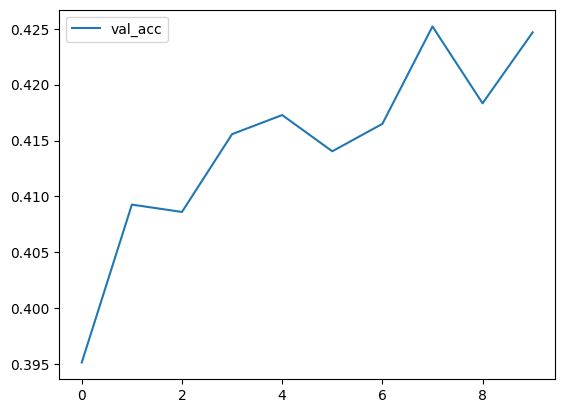

In [22]:
# plot accuracy per epoch
plt.plot([x['val_acc'].cpu() for x in model.epoch_metrics], label='val_acc')
plt.legend()
plt.show()